# FF-VUS

## Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
from itertools import combinations

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

experiments_path = os.path.join('..', '..', 'experiments')
save_fig_path = os.path.join(experiments_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
# Consistent color palette
color_palette = {
    'FF-VUS (L: 128)': '#c8b400',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

# Map shorthand names to formal names
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

# Default seaborn style
sns.set_style("whitegrid")

In [4]:
def finalize_plot(save_dir, filename):
    plt.tight_layout()
    if filename is not None:
        save_path = os.path.join(save_dir, filename)
        # plt.savefig(f"{save_path}.svg", bbox_inches='tight')
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

def load_results(path):
    result_files = [file for file in os.listdir(path) if file.endswith('.csv')]

    df = pd.DataFrame()
    for file in tqdm(result_files):
        file_path = os.path.join(path, file)
        curr_df = pd.read_csv(file_path, index_col=0).reset_index()
        df = pd.concat([df, curr_df], ignore_index=True)
    return df


## Experiment 1: All metrics with default parameters on the TSB-UAD benchmark

In [5]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 64.23it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
6991,YAHOO/YahooA4Benchmark-TS87_data.out,1679,1,1.0,NaN,AUC,0.017857,0.000606,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10765,YAHOO/YahooA4Benchmark-TS87_data.out,1679,1,1.0,128.0,FF-VUS (L: 128),0.918019,0.001106,optimized,1.0,...,0.000035,0.000072,0.000045,0.00009,0.00005,0.000074,0.000151,0.000381,0.000073,0.000045
8721,YAHOO/YahooA4Benchmark-TS62_data.out,1679,14,1.0,NaN,RF,0.000000,0.007979,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Runtime Box plots

In [6]:
# Average speed-ups compared to VUS
metric_to_compare = 'VUS (L: 128)'
speed_up_dict = {}

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    speed_up_dict[metric] = curr_speed_up.mean()
    print(f"{metric}: {speed_up_dict[metric]:.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


In [7]:
# Error of FF-VUS and FF-VUS-GPU compared to VUS
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()
dif_df.head(3)

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
Daphnet/S01R02E0.test.csv@1.out,0.0,1.677621e-08
Daphnet/S01R02E0.test.csv@4.out,0.0,7.568250e-07
Daphnet/S01R02E0.test.csv@6.out,0.0,5.137035e-08


In [8]:
# Average time per time series
for metric in df['Metric'].unique():
    mean_per_ts = df[df['Metric'] == metric]['Metric time'].mean()

    print(f"{metric}: {mean_per_ts:.6f} secs per ts")

Range-AUC (L: 128): 0.050070 secs per ts
VUS (L: 128): 3.126450 secs per ts
AFFILIATION: 0.034216 secs per ts
AUC: 0.005249 secs per ts
RF: 0.362132 secs per ts
FF-VUS (L: 128): 0.037790 secs per ts
FF-VUS-GPU (L: 128): 0.003939 secs per ts


In [9]:
# We use it at experiment 3
df_auc = df[df['Metric'] == 'AUC']

/tmp/ipykernel_12441/2392519477.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(0, 80)


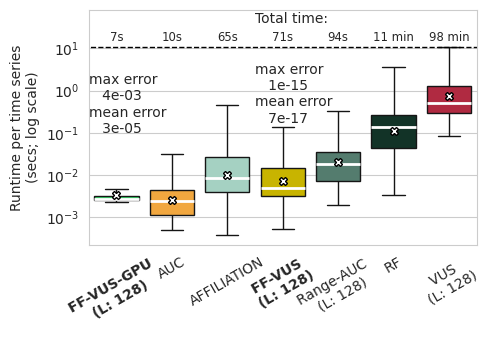

In [10]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].mean()
order = median_times.sort_values().index.to_list()

fig = plt.figure(figsize=(5, 3.5))

medianprops = dict(linestyle='-', linewidth=2, color='white')
meanprops = dict(
    marker='X',
    markerfacecolor='white',
    markeredgecolor='black',
    markersize=6
)

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=df,
    showfliers=False,
    log_scale=True,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime per time series\n(secs; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=30)
axis.grid(visible=False, axis='x')
axis.hlines(y=10.5, xmin=-1, xmax=7, linestyle='--', lw=1, color='k')
axis.set_xlim(-0.5, 6.5)
axis.set_ylim(0, 80)
axis.text(2.5, 40, 'Total time:')

for i, metric in enumerate(order):
    if 'FF-' in metric:
        axis.annotate(
            # f'{speed_up_dict[metric]:.0f}x faster\nmax error\n{dif_df[metric].max():.0e}', 
            f'max error\n   {dif_df[metric].max():.0e}\nmean error\n   {dif_df[metric].mean():.0e}', 
            xy=(i, 10), 
            xytext=((i - .5, 0.1 + i*0.025)),
            # bbox=dict(boxstyle='square', facecolor='white', alpha=0.8),
            # arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linestyle='--')
        )
    total = df.loc[df['Metric'] == metric, 'Metric time'].sum()
    if total > 100:
        label = f'{total/60:.0f} min'
    else:
        label = f'{total:.0f}s'
    axis.text(i, 25, label, ha='center', va='top', fontsize='small')
        

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

# # Remove borders around the boxes but keep whiskers and caps
# for j, patch in enumerate(axis.patches):
#     facecolor = patch.get_facecolor()
#     if all([x == 1 for x in facecolor]):
#         patch.set_facecolor((1, 1, 1, 0.0))  # alpha = 0.0
#         patch.set_edgecolor((0, 0, 0, 1.0))  # fully opaque border
#         patch.set_linewidth(1.5)

#         axis.lines[j * 6 + 4].set_color('black')    # 6 lines per box and usually the median is the 4th
#         axis.lines[j * 6 + 4].set_linewidth(1.5)
#     else:
#         patch.set_edgecolor(facecolor)
#         patch.set_linewidth(0.5)

finalize_plot(save_fig_path, 'exec_time_comparison_tsb')

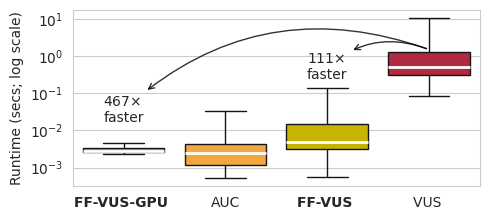

In [20]:
# What is the execution time difference
curr_df  = df[df['Metric'].isin(['AUC', 'FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'VUS (L: 128)'])]
median_times = curr_df.groupby('Metric')['Metric time'].mean()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(5, 2.3))

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=curr_df,
    showfliers=False,
    log_scale=True,
    showmeans=False,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Runtime (secs; log scale)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=0)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if 'FF-' in metric:
        axis.annotate(
            f'{speed_up_dict[metric]:.0f}$\\times$\nfaster', 
            xy=(3, 1.5), 
            xytext=(i-0.2, 0.09 + i*0.6),
            arrowprops=dict(arrowstyle="<-", connectionstyle="arc3,rad=-.3", color='k', alpha=0.8),
            # ha='center',
            va='top'
        )

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(L: 128)', '')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'exec_time_comparison_tsb_small')

### Error boxplot

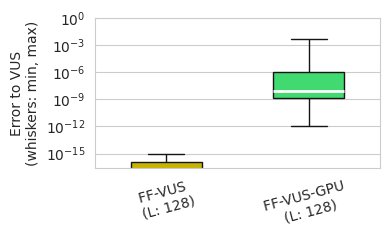

In [38]:
plt.figure(figsize=(4, 2.5))

axis = sns.boxplot(
    dif_df, 
    showfliers=False, 
    fill=True, 
    flierprops={"marker": "o"},
    medianprops=medianprops,
    width=.5, 
    palette=color_palette, 
    saturation=1,
    whis=[0, 100]
)
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')
axis.set_yscale('log')
axis.set_yticks([10**-x for x in range(0, 16)][::3])

# axis.annotate(f'Max error\n   9e-16', (0 - 0.2, 0.00005))
# axis.annotate(f'Max error\n   {dif_df['FF-VUS-GPU (L: 128)'].max():.3f}', (1 - 0.2, 0.00005))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'ffvus_error_analysis_tsb')

## Experiment 2: All metrics with default parameters on the synthetic datasets

In [39]:
curr_experiment_path = os.path.join(experiments_path, 'allmetrics_defparams_syn', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 70/70 [00:00<00:00, 322.00it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
817,syn_len_100000_n_5_avglen_10.npz,100000,5,10.000000,FF-VUS (L: 128),0.981041,0.040442,128.0,1.0,True,...,0.000146,0.000496,0.003155,0.020270,0.000211,0.000369,0.000330,0.012105,0.000131,0.000074
857,syn_len_536870912_n_10_avglen_10.npz,536870912,10,10.000000,FF-VUS (L: 128),0.740773,127.965791,128.0,1.0,True,...,0.467385,2.595701,24.526426,85.895121,0.000580,0.000830,0.000732,0.031355,0.000120,0.000087
3176,syn_len_100000_n_10_avglen_800.npz,100000,9,866.444444,RF,0.378347,0.512558,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time series characteristics runtime analysis

In [40]:
length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]

avg_anomaly_length_analysis_df.loc[:, 'Anomalies average length'] = avg_anomaly_length_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-1].replace('.npz', '')), axis=1)
n_anomalies_analysis_df.loc[:, 'Number of anomalies'] = n_anomalies_analysis_df.apply(lambda row: int(row['Time series'].split('_')[-3]), axis=1)

analysis_dfs = [
    length_analysis_df, 
    n_anomalies_analysis_df, 
    avg_anomaly_length_analysis_df
]
attributes = ["Length", "Number of anomalies", "Anomalies average length"]

/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/matplotlib/scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/tmp/ipykernel_23768/693262018.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


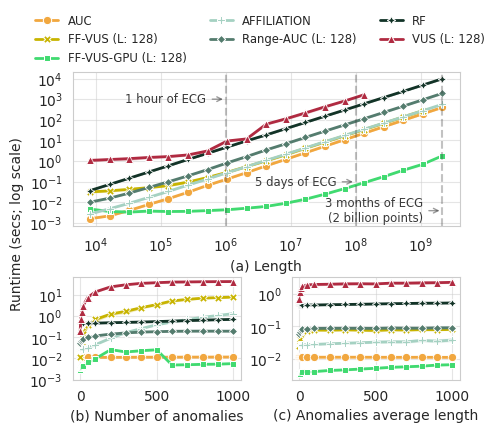

In [41]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 2], wspace=0.3, hspace=0.4)
attr_axis = {
    "Length": gs[0, :],
    "Number of anomalies": gs[1, 0],
    "Anomalies average length": gs[1, 1],
}
abc_numbered = {0: 'a', 1: 'b', 2: 'c'}

legend_axis = None
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(attr_axis[attribute])
    curr_df = analysis_dfs[i]

    sns.lineplot(
        x=attribute,
        y='Metric time',
        hue='Metric',
        data=curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes=False,
        linewidth=2,
        zorder=1,
        estimator=np.median
    )
    axis.set_yscale('log')
    axis.grid(axis='both', alpha=0.5)
    axis.set_xlabel(f"({abc_numbered[i]}) {attribute}")
    axis.set_ylabel('')

    if attribute == "Length":
        axis.set_xscale('log', base=10)
    if i != 0:
        axis.get_legend().remove()
        if i == 1:
            axis.set_yticks([0.001, 0.01, 0.1, 1, 10])    
    else:
        legend_axis = axis

        axis.set_yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])

        # 1 million points (~1 hour of ECG)
        x_val = 1e6
        y_val = 1000
        curr_color = "#383838"
        axis.annotate("1 hour of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 100 million points (~5 days of ECG)
        x_val = 1e8
        y_val = 0.1
        axis.annotate("5 days of ECG",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

        # 1 billion points (~3 months of ECG)
        x_val = 2**31
        y_val = 0.004
        axis.annotate("3 months of ECG\n(2 billion points)",
                    xy=(x_val, y_val), xytext=(x_val / 2, y_val),
                    ha='right', va='center', fontsize='small', color=curr_color,
                    arrowprops=dict(arrowstyle="->", color=curr_color, alpha=0.5))
        axis.axvline(x=x_val, ymin=0, ymax=20000, color=curr_color, linestyle='--', alpha=0.3)

fig.text(
    0, 0.5,
    "Runtime (secs; log scale)",
    va='center',
    rotation='vertical',
)

if legend_axis:
    handles, labels = legend_axis.get_legend_handles_labels()
    legend_axis.get_legend().remove()
    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=(len(labels)//2),
        # nrow=2,
        frameon=False,
        fontsize='small'
    )
finalize_plot(save_fig_path, 'exec_time_per_ts_char_syn')

### Computation step runtime analysis

In [55]:
rename_dict = {
    'Anomaly coordinates time': 'Anom.',
    'Safe mask time': 'Mask',
    'Thresholds time': 'Thresh.',
    'Score mask time': 'Scores',
    'Position time': 'Pos.',
    'Slopes time': 'Buffers',
    'Existence time': 'Existence',
    'Confusion matrix time': 'Conf. mat.',
    'Precision recall curve time': 'PR curve',
    'Integral time': 'Integral',
}
rename_dict = {k: f'({chr(i + 97)}) {v}' for i, (k, v) in enumerate(rename_dict.items())}

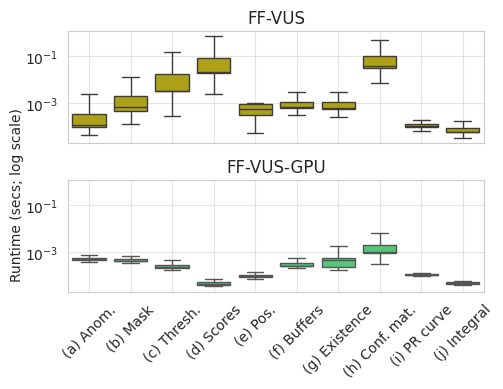

In [56]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharey=True)
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(
            curr_df[curr_df['Metric'] == metrics[j]], 
            ax=axis, 
            x=i, 
            y=col, 
            log_scale=True, 
            legend=(i == 0), 
            color=color_palette[metrics[j]], 
            showfliers=False
        )
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])

        axis.set_title(metrics[j].replace(' (L: 128)', ''))
        axis.set_ylabel('')
        axis.set_xlabel('')
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='both', alpha=0.5)

fig.text(
    0, 0.5,
    "Runtime (secs; log scale)",
    va='center',
    rotation='vertical',
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

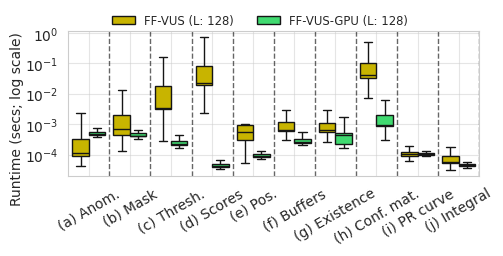

In [67]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
curr_df = df[df['Metric'].isin(metrics)]

fig, axis = plt.subplots(1, 1, figsize=(5, 2.5))
for i, col in enumerate(time_analysis_cols):
    sns.boxplot(
        curr_df, 
        ax=axis, 
        x=i, 
        y=col, 
        log_scale=True, 
        legend=(i == 0), 
        hue='Metric',
        palette=color_palette, 
        showfliers=False,
        saturation=1
    )
    if j != 0:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [rename_dict[x] for x in time_analysis_cols])
    else:
        axis.set_xticks(np.arange(len(time_analysis_cols)), [])

    axis.axvline(x=i+0.5, linestyle='--', color='k', lw=1, alpha=0.6)
axis.set_title('')
axis.set_ylabel('')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=30)
axis.grid(axis='both', alpha=0.5)
axis.legend()

fig.text(
    0, 0.57,
    "Runtime (secs; log scale)",
    va='center',
    rotation='vertical',
)

handles, labels = axis.get_legend_handles_labels()
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'per_part_runtime_syn')

## Experiment 3: VUS / Buffer & Step comparison / TSB

### Buffer comparison

In [68]:
curr_experiment_path = os.path.join(experiments_path, 'vus_buffer_comparison_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 30/30 [00:00<00:00, 79.60it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
33146,YAHOO/Yahoo_A1real_47_data.out,1426,5,2.0,256,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.961021,0.599354
33030,SMD/machine-2-1.test.csv@21.out,23693,13,90.0,256,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.375737,4.374314
40291,OPPORTUNITY/S1-ADL5.test.csv@82.out,30047,2,609.0,128,1.0,True,precomputed,optimized,dynamic_plus,...,0.000678,0.00015,0.000269,0.000335,0.00201,0.000173,0.000075,FF-VUS (L: 128),0.065315,0.005816


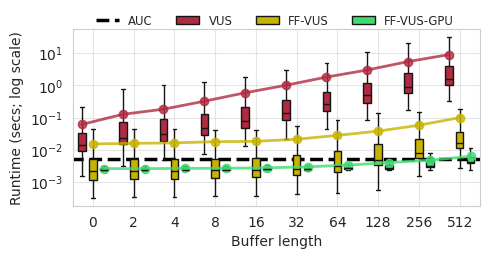

In [71]:
order = ['VUS (L: 128)', 'FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, axis = plt.subplots(1, 1, figsize=(5, 2.5))

# First create the boxplot
axis.hlines(y=df_auc['Metric time'].mean(), xmin=-1, xmax=10, linestyle='--', lw=2.5, color='k', label='AUC')
sns.boxplot(
    ax=axis,
    y='Metric time', 
    x='Slope size', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    saturation=1,
    gap=.3,
    hue_order=order
)


# Add lines connecting means for each metric
for i, metric in enumerate(order):
    means = df[df['Metric'] == metric].groupby('Slope size')['Metric time'].mean()
    axis.plot(np.arange(len(means)) + (i - 1) * 0.27, means, '-o', lw=2, label=f'{metric} mean', alpha=0.8, color=color_palette[metric])

plt.xlabel('Buffer length')
plt.ylabel('Runtime (secs; log scale)')
plt.grid(axis='both', alpha=0.5)
axis.set_xlim(-0.5, 9.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', '').replace(' mean', '') for label in labels[:4]]
axis.get_legend().remove()
fig.legend(
    handles[:4],
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'exec_time_buffer_comparison')

### Step comparison

In [72]:
curr_experiment_path = os.path.join(experiments_path, 'vus_step_comparison_tsb', 'results')
df_step = load_results(curr_experiment_path)    
df_step['Metric'] = df_step['Metric'].map(formal_names)
df_step.sample(3)

100%|██████████| 20/20 [00:00<00:00, 85.63it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
28603,OPPORTUNITY/S1-ADL2.test.csv@109.out,32223,2,697.5,512,4,True,precomputed,optimized,dynamic_plus,...,0.000562,0.000258,0.000650,0.000243,0.003538,0.000079,0.000059,FF-VUS (L: 128),0.09258,0.007055
4262,OPPORTUNITY/S1-ADL3.test.csv@78.out,32499,2,647.0,512,32,True,function,True,dynamic_plus,...,0.000034,0.000070,0.000192,0.000159,0.000348,0.000097,0.000036,FF-VUS-GPU (L: 128),0.09629,0.002563
19686,SMD/machine-2-3.test.csv@16.out,23688,10,26.9,512,512,True,function,True,dynamic_plus,...,0.000033,0.000073,0.000208,0.000161,0.000287,0.000089,0.000035,FF-VUS-GPU (L: 128),0.23258,0.002460


In [ ]:
df_vus_512 = df[np.logical_and(df['Metric'] == 'VUS (L: 128)', df['Slope size'] == 512)]

In [74]:
df_vus_512_control = df_vus_512.set_index('Time series')['Metric value']

df_step['Error'] = df_step.apply(lambda row: row['Metric value'] - df_vus_512_control.loc[row['Time series']], axis=1)
df_step.sample(3)

,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Error
25222,OPPORTUNITY/S1-ADL5.test.csv@38.out,30047,2,609.000000,512,128,True,function,True,dynamic_plus,...,0.000071,0.000195,0.000168,0.000262,0.000087,0.000036,FF-VUS-GPU (L: 128),0.129587,0.002406,0.002609
17028,Genesis/genesis-anomalies.test.csv@17.out,16219,3,16.666667,512,64,True,precomputed,optimized,dynamic_plus,...,0.000093,0.000076,0.000216,0.000472,0.000032,0.000025,FF-VUS (L: 128),0.040611,0.002037,-0.000597
17634,OPPORTUNITY/S1-ADL4.test.csv@94.out,32698,2,500.000000,512,64,True,precomputed,optimized,dynamic_plus,...,0.000152,0.000062,0.000092,0.000654,0.000039,0.000023,FF-VUS (L: 128),0.345167,0.002874,-0.000269


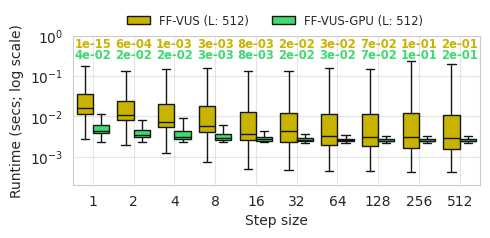

In [83]:
fig, axis = plt.subplots(1, 1, figsize=(5, 2.3))
# plt.hlines(df_vus_512['Metric time'].mean(), xmin=-1, xmax=512, lw=2.5, color=color_palette['VUS (L: 128)'], linestyle='--', label='VUS (L: 512)')
sns.boxplot(
    y='Metric time', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis
)
axis.set_xlabel('Step size')
axis.set_ylabel('Runtime (secs; log scale)')
axis.tick_params(axis='x', labelrotation=0)
axis.grid(axis='both', alpha=0.5)
axis.set_ylim(0.0002, 1)

# annotate error info above each Step box
steps = sorted(df_step['Step'].dropna().unique())
for i, s in enumerate(steps):
    errs = df_step.loc[df_step['Step'] == s, 'Error'].abs()
    
    for j, metric in enumerate(metrics[::-1]):
        axis.text(i, 
            .23 + j*0.2, 
            f'{df_step[np.logical_and(df_step['Metric'] == metric, df_step['Step'] == s)]['Error'].max():.0e}', 
            ha='center', 
            va='bottom', 
            fontsize='small',
            color=color_palette[metric],
            weight='bold',
            # bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
        )

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'step_comparison')

/home/sylli/anaconda3/envs/ffvus/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


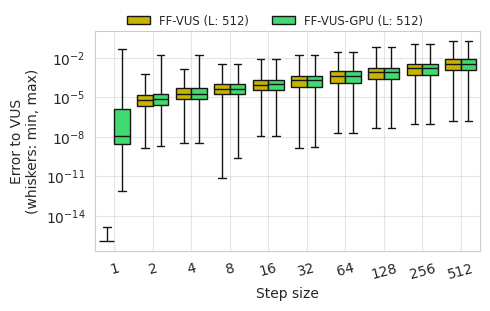

In [84]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))    
sns.boxplot(
    y='Error', 
    x='Step', 
    data=df_step, 
    showfliers=False, 
    log_scale=True,
    hue='Metric',
    palette=color_palette,
    saturation=1,
    ax=axis,
    whis=[0, 100]
)
axis.set_xlabel('Step size')
axis.set_ylabel('Error to VUS\n(whiskers: min, max)')
axis.tick_params(axis='x', labelrotation=15)
# axis.set_yticks([10**i for i in range(-3, 4)])
axis.grid(axis='both', alpha=0.5)

handles, labels = axis.get_legend_handles_labels()
labels = [label.replace(' (L: 128)', ' (L: 512)') for label in labels]
axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.56, 1.04),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

finalize_plot(save_fig_path, 'error_step_comparison')

### Step, preservation of ordering test

In [ ]:
baseline = df_vus_512[['Time series', 'Metric value']].rename(
    columns={'Metric value': 'VUS'}
).set_index('Time series')

df_step_small = df_step[
    df_step['Metric'].isin(['FF-VUS', 'FF-VUS-GPU'])
][['Time series', 'Metric', 'Step', 'Metric value']]

rename_dict = {"FF-VUS (L: 128)": "FF-VUS", "FF-VUS-GPU (L: 128)": "FF-VUS-GPU"}
df_step_small = df_step_small.replace({'Metric': rename_dict})
df_step_small

In [100]:
import numpy as np
import pandas as pd

def order_flips(a, b):
    flips = 0
    total = 0
    for i, j in combinations(range(len(a)), 2):
        total += 1
        if (a[i] < a[j]) != (b[i] < b[j]):
            flips += 1
    return flips / total


results = []

for step, df_step_s in df_step_small.groupby("Step"):

    df_pivot = df_step_s.pivot(index="Time series", columns="Metric", values="Metric value")

    # Align with baseline
    merged = baseline.join(df_pivot, how="inner").dropna()

    # Extract vectors
    vus = merged['VUS']
    ff     = merged['FF-VUS']
    ff_gpu = merged['FF-VUS-GPU']

    # Compute ranks
    vus_r     = vus.rank()
    ff_r      = ff.rank()
    ff_gpu_r  = ff_gpu.rank()

    # Save metrics
    results.append({
        "Step": step,
        "Spearman(FF, VUS)": ff_r.corr(vus_r, method="spearman"),
        "Spearman(FF-GPU, VUS)": ff_gpu_r.corr(vus_r, method="spearman"),
        "Kendall(FF, VUS)": ff_r.corr(vus_r, method="kendall"),
        "Kendall(FF-GPU, VUS)": ff_gpu_r.corr(vus_r, method="kendall"),
        "Mean rank diff (FF)": np.abs(ff_r - vus_r).mean(),
        "Mean rank diff (FF-GPU)": np.abs(ff_gpu_r - vus_r).mean(),
        "Order flips (FF)": order_flips(vus_r.values, ff_r.values),
        "Order flips (FF-GPU)": order_flips(vus_r.values, ff_gpu_r.values),
    })

results_df = pd.DataFrame(results).sort_values("Step")
results_df


,Step,"Spearman(FF, VUS)","Spearman(FF-GPU, VUS)","Kendall(FF, VUS)","Kendall(FF-GPU, VUS)",Mean rank diff (FF),Mean rank diff (FF-GPU),Order flips (FF),Order flips (FF-GPU)
0,1,1.000000,0.999943,1.000000,0.998192,0.000000,1.430843,0.000000,0.000904
1,2,0.999999,0.999958,0.999689,0.998417,0.259671,1.312136,0.000156,0.000791
2,4,0.999993,0.999988,0.999106,0.998908,0.696343,0.863805,0.000447,0.000546
3,8,0.999967,0.999967,0.997908,0.997895,1.551669,1.555909,0.001046,0.001053
4,16,0.999879,0.999879,0.995904,0.995912,2.983572,2.978272,0.002048,0.002044
5,32,0.999513,0.999513,0.991184,0.991171,6.349762,6.355061,0.004408,0.004414
6,64,0.998781,0.998780,0.983015,0.983010,11.846317,11.847377,0.008493,0.008495
7,128,0.996607,0.996606,0.967143,0.967142,23.094860,23.094860,0.016428,0.016429
8,256,0.991661,0.991661,0.940643,0.940643,41.392687,41.392687,0.029678,0.029678
9,512,0.977544,0.977544,0.892972,0.892972,75.881293,75.882353,0.053513,0.053513


In [108]:
# -------------------------
# Helper to compute order flips
# -------------------------
def order_flips(a, b):
    flips = 0
    total = 0
    for i, j in combinations(range(len(a)), 2):
        total += 1
        if (a[i] < a[j]) != (b[i] < b[j]):
            flips += 1
    return flips / total


# ------------------------------------------------------
# 1. PREPARE BASELINE (VUS L=128 / slope size = 512)
# ------------------------------------------------------
df_vus_512 = df[
    (df['Metric'] == 'VUS (L: 128)') &
    (df['Slope size'] == 512)
].copy()

baseline = df_vus_512[['Time series', 'Metric value']] \
    .rename(columns={'Metric value': 'VUS'}) \
    .set_index('Time series')


# ------------------------------------------------------
# 2. PREPARE FF-VUS & FF-VUS-GPU ACROSS STEPS
# ------------------------------------------------------
df_step_small = df_step[
    df_step['Metric'].isin(['FF-VUS', 'FF-VUS-GPU'])
][['Time series', 'Metric', 'Step', 'Metric value']]


# ------------------------------------------------------
# 3. COMPUTE METRICS FOR EACH STEP
# ------------------------------------------------------
results = []

for step, df_step_s in tqdm(df_step_small.groupby("Step")):

    df_pivot = df_step_s.pivot(
        index="Time series",
        columns="Metric",
        values="Metric value"
    )

    merged = baseline.join(df_pivot, how="inner").dropna()

    vus = merged['VUS']
    ff = merged['FF-VUS']
    ff_gpu = merged['FF-VUS-GPU']

    vus_r = vus.rank()
    ff_r = ff.rank()
    ff_gpu_r = ff_gpu.rank()

    results.append({
        "Step": step,
        "Spearman FF": vus_r.corr(ff_r, method="spearman"),
        "Spearman FF-GPU": vus_r.corr(ff_gpu_r, method="spearman"),
        "Kendall FF": vus_r.corr(ff_r, method="kendall"),
        "Kendall FF-GPU": vus_r.corr(ff_gpu_r, method="kendall"),
        "Mean rank diff FF": np.abs(ff_r - vus_r).mean(),
        "Mean rank diff FF-GPU": np.abs(ff_gpu_r - vus_r).mean(),
        "Order flips FF": order_flips(vus_r.values, ff_r.values),
        "Order flips FF-GPU": order_flips(vus_r.values, ff_gpu_r.values),
    })

results_df = pd.DataFrame(results).sort_values("Step")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:13<00:00,  7.37s/it]


In [110]:
results_df

,Step,Spearman FF,Spearman FF-GPU,Kendall FF,Kendall FF-GPU,Mean rank diff FF,Mean rank diff FF-GPU,Order flips FF,Order flips FF-GPU
0,1,1.000000,0.999943,1.000000,0.998192,0.000000,1.430843,0.000000,0.000904
1,2,0.999999,0.999958,0.999689,0.998417,0.259671,1.312136,0.000156,0.000791
2,4,0.999993,0.999988,0.999106,0.998908,0.696343,0.863805,0.000447,0.000546
3,8,0.999967,0.999967,0.997908,0.997895,1.551669,1.555909,0.001046,0.001053
4,16,0.999879,0.999879,0.995904,0.995912,2.983572,2.978272,0.002048,0.002044
5,32,0.999513,0.999513,0.991184,0.991171,6.349762,6.355061,0.004408,0.004414
6,64,0.998781,0.998780,0.983015,0.983010,11.846317,11.847377,0.008493,0.008495
7,128,0.996607,0.996606,0.967143,0.967142,23.094860,23.094860,0.016428,0.016429
8,256,0.991661,0.991661,0.940643,0.940643,41.392687,41.392687,0.029678,0.029678
9,512,0.977544,0.977544,0.892972,0.892972,75.881293,75.882353,0.053513,0.053513


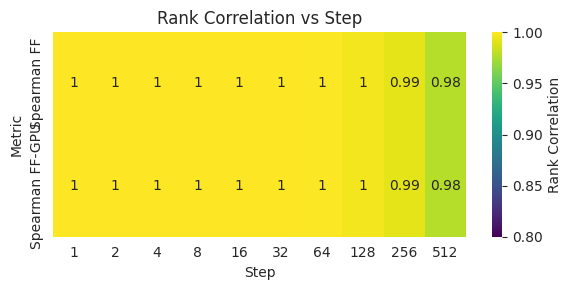

In [109]:
# Select only the correlation columns
corr_df = results_df[
    ["Step", "Spearman FF", "Spearman FF-GPU"]
].set_index("Step")

plt.figure(figsize=(6, 3))
sns.heatmap(
    corr_df.T,
    annot=True,
    cmap="viridis",
    vmin=0.8, vmax=1.0,
    cbar_kws={"label": "Rank Correlation"}
)
plt.title("Rank Correlation vs Step")
plt.xlabel("Step")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

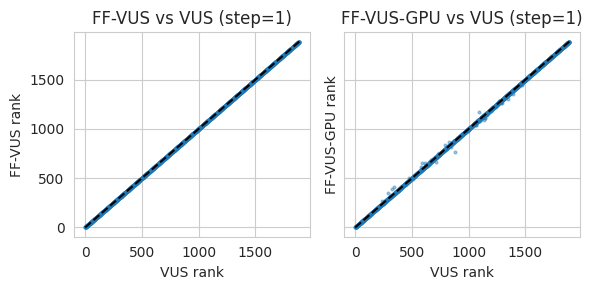

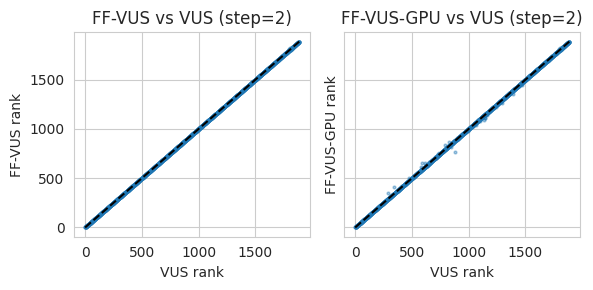

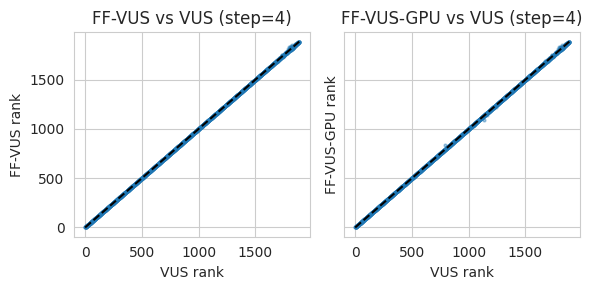

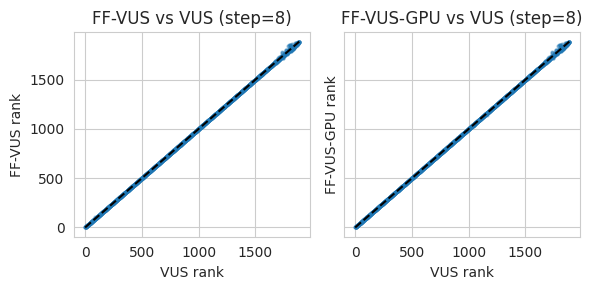

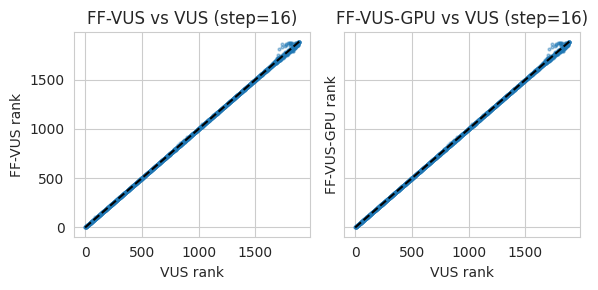

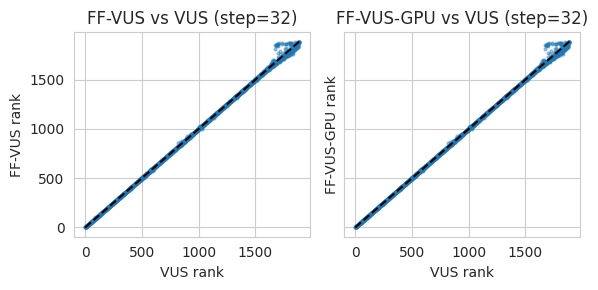

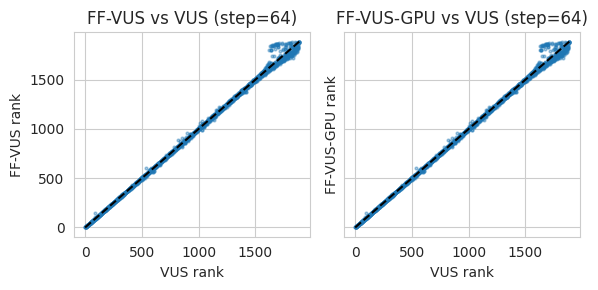

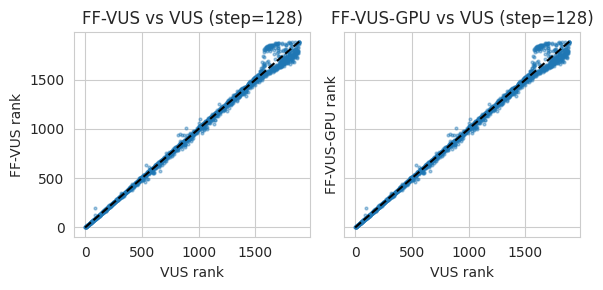

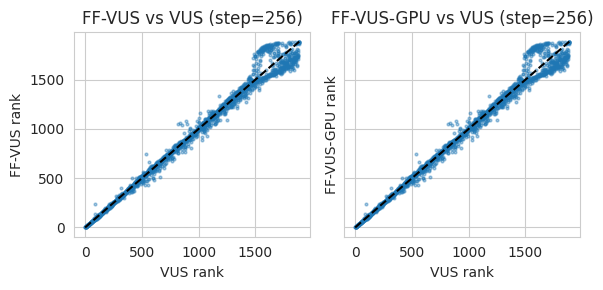

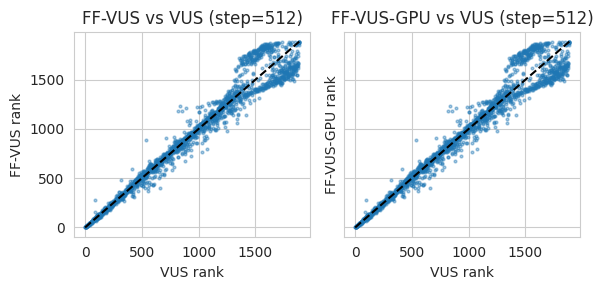

In [113]:
for step in results_df["Step"]:
    df_step_s = df_step_small[df_step_small["Step"] == step]
    df_pivot = df_step_s.pivot(
        index="Time series",
        columns="Metric",
        values="Metric value"
    )
    merged = baseline.join(df_pivot, how="inner").dropna()

    vus_r = merged['VUS'].rank()
    ff_r = merged['FF-VUS'].rank()
    ff_gpu_r = merged['FF-VUS-GPU'].rank()

    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    # FF-VUS scatter
    ax[0].scatter(vus_r, ff_r, s=4, alpha=0.4)
    ax[0].plot([0, len(vus_r)], [0, len(vus_r)], 'k--')
    ax[0].set_title(f"FF-VUS vs VUS (step={step})")
    ax[0].set_xlabel("VUS rank")
    ax[0].set_ylabel("FF-VUS rank")

    # FF-VUS-GPU scatter
    ax[1].scatter(vus_r, ff_gpu_r, s=4, alpha=0.4)
    ax[1].plot([0, len(vus_r)], [0, len(vus_r)], 'k--')
    ax[1].set_title(f"FF-VUS-GPU vs VUS (step={step})")
    ax[1].set_xlabel("VUS rank")
    ax[1].set_ylabel("FF-VUS-GPU rank")

    plt.tight_layout()
    plt.show()


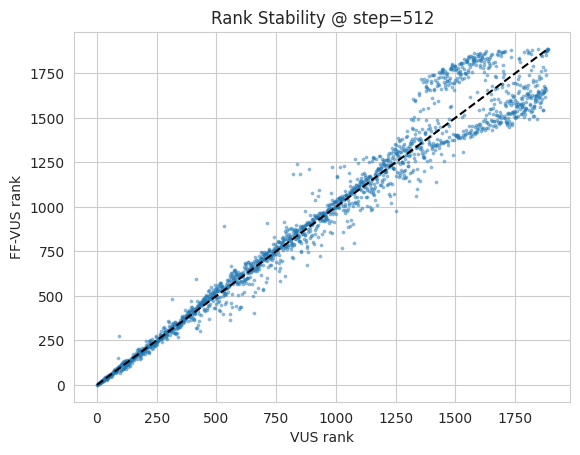

In [ ]:
step = 512  # choose step
df_pivot = df_step_small[df_step_small["Step"] == step].pivot(
    index="Time series", columns="Metric", values="Metric value"
)
merged = baseline.join(df_pivot, how="inner").dropna()

vus_r     = merged['VUS'].rank()
ff_r      = merged['FF-VUS'].rank()

plt.scatter(vus_r, ff_r, s=3, alpha=0.4)
plt.xlabel("VUS rank")
plt.ylabel("FF-VUS rank")
plt.title(f"Rank Stability @ step={step}")
plt.plot([0, len(vus_r)], [0, len(vus_r)], 'k--')
plt.show()

## Experiment 4: Equivalence to AUC

In [ ]:
curr_experiment_path = os.path.join(experiments_path, 'vus_ffvus_auc_0_tsb', 'results')
df = load_results(curr_experiment_path)    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 4/4 [00:00<00:00, 109.64it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
4269,OPPORTUNITY/S1-ADL5.test.csv@90.out,30047,2,609.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUC,0.107421,0.002552
5826,IOPS/KPI-c69a50cf-ee03-3bd7-831e-407d36c7ee91....,149158,59,11.898305,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.004193,0.108525
6425,SMD/machine-2-4.test.csv@19.out,23688,20,84.700000,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),0.112668,0.024168


In [232]:
values_df = df[['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.copy()
for metric in metrics: 
    dif_df[metric] = values_df[metric] - values_df['AUC']

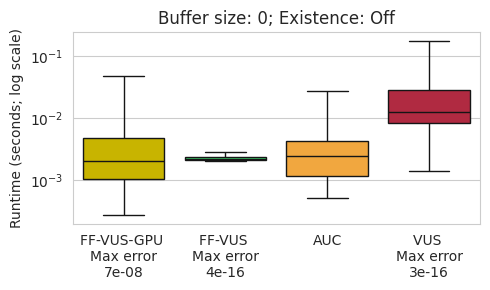

In [ ]:
metrics = df['Metric'].unique()
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

fig, axis = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    ax=axis,
    saturation=1
)
axis.set_xlabel('')
axis.set_ylabel('Runtime (secs; log scale)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', f'\nMax error\n{dif_df.max()[x]:.0e}') for x in metrics])

finalize_plot(save_fig_path, 'exec_time_auc_equivalence')

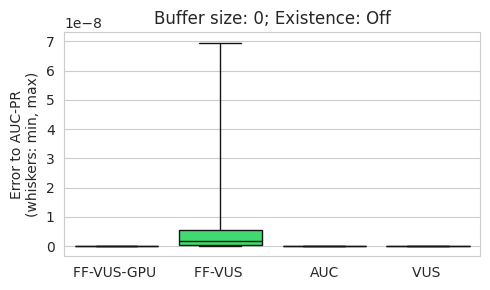

In [230]:
fig, axis = plt.subplots(1, 1, figsize=(5, 3))

sns.boxplot(
    dif_df.abs(), 
    showfliers=True, 
    palette=color_palette, 
    order=order, 
    log_scale=False, 
    ax=axis,
    saturation=1,
    whis=[0, 100]
)
axis.set_xlabel('')
axis.set_ylabel('Error to AUC-PR\n(whiskers: min, max)')
axis.set_title('Buffer size: 0; Existence: Off')
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '(L: 0, E: Off)') for x in metrics])
axis.set_xticks(np.arange(len(metrics)), [x.replace('(L: 128)', '') for x in metrics])

finalize_plot(save_fig_path, 'error_auc_equivalence')